In [1]:
import os
from pathlib import Path
from copy import deepcopy
from typing import (
    Dict,
    List,
    Callable
)
from os.path import join
from functools import partial
from pdb import set_trace

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_kernels

import gc4eptn
from gc4eptn import dataloaders
from gc4eptn.utils import norms
from gc4eptn.utils.utils import (
    get_module_root, 
    filter_df, 
    get_dataloader,
    float_exponent_notation,
    extract_dir_path,
    build_experiment_path
)
from gc4eptn.utils.kernels import (
    corr,
    cov,
    gram,
    rational_quadratic,
    weighted_kernel,
)

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

# Kernel Analysis

In [2]:
from gc4eptn.utils.kernel_analysis import KernelAnalysis

### Directory Structure Params

In [3]:
# Data Params
dataset_type = 'rtds' # Selecte matpower or rtds
dataset_version = 'v5' # Select version based on type
difficulty = 'novice' # Select data difficulty (e.g., novice, intermediate)
topology = 'complete' # (optional) set topology type (e.g., partial-left, complete)
drop_current = True # (optional) Drop current (I) data
n_samples = None # Number of samples to use (None uses all samples)

In [4]:
difficulty = difficulty.lower()
dataset_version = dataset_version.lower()
features = 'vc' if not drop_current else 'volt'
pmuds_kwargs = {}
default_kwargs = dict(
    drop_current=drop_current,
)

# Build correct PMU class
pmuds_class = get_dataloader(dataset_type, dataset_version, difficulty)
if dataset_type == 'rtds':
    features = 'vc' if not drop_current else 'volt'
    pmuds_kwargs['load=high'] = dict(load='high', topology=topology, **default_kwargs)
    pmuds_kwargs['load=medium'] = dict(load='medium', topology=topology, **default_kwargs)
    pmuds_kwargs['load=low'] = dict(load='low', topology=topology, **default_kwargs)
    pmuds_kwargs['load=all'] = dict(load=['high', 'medium', 'low'], topology=topology, **default_kwargs)

elif dataset_type == 'matpower':
    topology = '' # No topology changes 
    features = 'volt' # No current data
    pmuds_kwargs['80-90'] = dict(load='80-90')
    pmuds_kwargs['100-110'] = dict(load='100-110')
    pmuds_kwargs['110-120'] = dict(load='110-120')
    pmuds_kwargs['80-120'] = dict(load='80-120')
    
assert issubclass(pmuds_class, (dataloaders.IntermediatePMUData, dataloaders.NovicePMUData)), f"Got {pmuds_class}"

# Set specific params based on difficulty of EPTN.
if difficulty.startswith('novice'):
    fmt='.3f'
    annot_kws={"fontsize":8}
elif difficulty.startswith('intermediate'):
    fmt='.2f'
    annot_kws={"fontsize":6}
else:
    raise ValueError("Difficulty not found! Can not set `annot_kws`.")

# Build experiement path for saving
features_dir = f"feat={features}"
samples_dir = f"n={n_samples or 'all'}"

exp_path = build_experiment_path(
    subdirs=[
        dataset_type,
        dataset_version,
        'cov-analysis',
        '{exp_type}',
        difficulty,
        topology,
        features_dir, 
        samples_dir, 
    ]
) 

multi_exp_path = Path(str(exp_path).format(exp_type='multi'))
single_exp_path = Path(str(exp_path).format(exp_type='single'))
print(multi_exp_path)
print(single_exp_path)
print(pmuds_class)
print(pmuds_kwargs)

/home/ben/space/modl/gc4eptn/exps/rtds/v5/cov-analysis/multi/novice/complete/feat=volt/n=all
/home/ben/space/modl/gc4eptn/exps/rtds/v5/cov-analysis/single/novice/complete/feat=volt/n=all
<class 'gc4eptn.dataloaders.rtds_loader.NovicePMUDataRTDSV5'>
{'load=high': {'load': 'high', 'topology': 'complete', 'drop_current': True}, 'load=medium': {'load': 'medium', 'topology': 'complete', 'drop_current': True}, 'load=low': {'load': 'low', 'topology': 'complete', 'drop_current': True}, 'load=all': {'load': ['high', 'medium', 'low'], 'topology': 'complete', 'drop_current': True}}


### `CovarianceAnalysis` Params

In [5]:
build_graph_kwargs = dict(
    raw=dict(
        n=n_samples,
        norm_fn=None,
    ),
    fstandardize=dict(
        n=n_samples,
        norm_fn=partial(
            norms.feature_norm,
            norm_fn=norms.standardize,
            features=['V_.*ma', 'V_.*an', 'I_.*an', 'I_.*ma']
        )
    ),
)

# Multi-Experiment Runner

In [6]:
multi_exp_path.mkdir(parents=True, exist_ok=True)

### Define CovarianceAnalysis for Magnitude and Angle

In [7]:
# Mag+Angle
power_ma_ca = KernelAnalysis(
    pmuds_class=pmuds_class,
    pmuds_kwargs=pmuds_kwargs,
    build_graph_kwargs=build_graph_kwargs,
    save_dir_path=multi_exp_path
)
print(pmuds_kwargs)
print('-'*50)
# Mag only 
pmuds_mag_kwargs = deepcopy(pmuds_kwargs)
for _, value in pmuds_mag_kwargs.items():
    value['drop_angle'] = True
power_mag_ca = KernelAnalysis(
    pmuds_class=pmuds_class,
    pmuds_kwargs=pmuds_mag_kwargs,
    build_graph_kwargs=build_graph_kwargs,
    save_dir_path=multi_exp_path
)
print(pmuds_mag_kwargs)
print('-'*50)
# Angle Only
pmuds_an_kwargs = deepcopy(pmuds_kwargs)
for _, value in pmuds_an_kwargs.items():
    value['drop_magnitude'] = True 
power_ang_ca = KernelAnalysis(
    pmuds_class=pmuds_class,
    pmuds_kwargs=pmuds_an_kwargs,
    build_graph_kwargs=build_graph_kwargs,
    save_dir_path=multi_exp_path
)
print(pmuds_an_kwargs)

{'load=high': {'load': 'high', 'topology': 'complete', 'drop_current': True}, 'load=medium': {'load': 'medium', 'topology': 'complete', 'drop_current': True}, 'load=low': {'load': 'low', 'topology': 'complete', 'drop_current': True}, 'load=all': {'load': ['high', 'medium', 'low'], 'topology': 'complete', 'drop_current': True}}
--------------------------------------------------
{'load=high': {'load': 'high', 'topology': 'complete', 'drop_current': True, 'drop_angle': True}, 'load=medium': {'load': 'medium', 'topology': 'complete', 'drop_current': True, 'drop_angle': True}, 'load=low': {'load': 'low', 'topology': 'complete', 'drop_current': True, 'drop_angle': True}, 'load=all': {'load': ['high', 'medium', 'low'], 'topology': 'complete', 'drop_current': True, 'drop_angle': True}}
--------------------------------------------------
{'load=high': {'load': 'high', 'topology': 'complete', 'drop_current': True, 'drop_magnitude': True}, 'load=medium': {'load': 'medium', 'topology': 'complete', 

### Define Kernels

- Weighted: Computes kernel matrices separately for magnitude and voltage and then combines them|
- Flatten: Computes one kernel matrix using both magnitude and voltage features. Does so by flattening the features. 

In [8]:
rqk = partial(rational_quadratic, length_scale=50, alpha=1.0)
rbf = partial(pairwise_kernels, metric='rbf')

flatten_params = [
    # dict(
    #     name='corr',
    #     kernel_fn=corr
    # ),
    # dict(
    #     name='cov',
    #     kernel_fn=cov
    # ),
    # dict(
    #     name='gram',
    #     kernel_fn=partial(gram, transpose=True)
    # ),
    dict(
        name='rqk',
        kernel_fn=rqk
    ),
    # dict(
    #     name='rbf',
    #     kernel_fn=rbf
    # ),
]

weighted_params = [
    # dict(
    #     name='wcorr',
    #     kernel_fn=partial(weighted_kernel, kernel=corr)
    # ),
    # dict(
    #     name='wcov',
    #     kernel_fn=partial(weighted_kernel, kernel=cov)
    # ),
    # dict(
    #     name='wgram',
    #     kernel_fn=partial(weighted_kernel, kernel=partial(gram, transpose=True))
    # ),
    # dict(
    #     name='wrqk',
    #     kernel_fn=partial(weighted_kernel, kernel=rqk)
    # ),
    # dict(
    #     name='wrbf',
    #     kernel_fn=partial(weighted_kernel, kernel=rbf)
    # ),
]

### Utils

In [11]:
def save_adj_ground_truth(save: bool =  False):
    ax = sns.heatmap(
        pmuds_class.true_network_graph(), 
        cmap="coolwarm", 
        linewidth=.5,
        vmin=-1, 
        vmax=1, 
        square=True,
        cbar=False,
        annot=False,
        xticklabels=pmuds_class.labels.values(), 
        yticklabels=pmuds_class.labels.values(),  
    )
    ax.set_title(f'{dataset_version}-{difficulty}-adj')
    if save:
        diff_path = extract_dir_path(multi_exp_path, difficulty)
        ax.figure.savefig(diff_path/f'{dataset_version}_{difficulty}_adj.pdf')
    else:
        plt.show()
    plt.clf()
  

def run_multi_kernel_analysis(ca, exp_params, exp_name):
    summary_path = ca.save_dir_path/'summary'
    summary_path.mkdir(parents=True, exist_ok=True)
    # save_adj_ground_truth(save=True)

    for params in exp_params:
        print("{:=^50}".format(params['name']))
        name = f"{exp_name}-{params['name']}"
        title_prefix = f"{dataset_version}-{exp_name}-{params['name']}"
        cond_df = ca(
            kernel_fn=params['kernel_fn'], 
            title=title_prefix + '\n{0} norm={1}', 
            annot_kws=annot_kws,
            fmt=fmt,
            save_filename=f"{name}.pdf",
            save=True,
        )
        display(cond_df)
        fmt_cond_df = cond_df.map(lambda x:float_exponent_notation(x))
        summary = fmt_cond_df.to_latex()
        print(summary)
        with open(summary_path/f"{name}.txt", "w") as f:
            f.write(summary)

## All PMU Features

=======================rqk========================


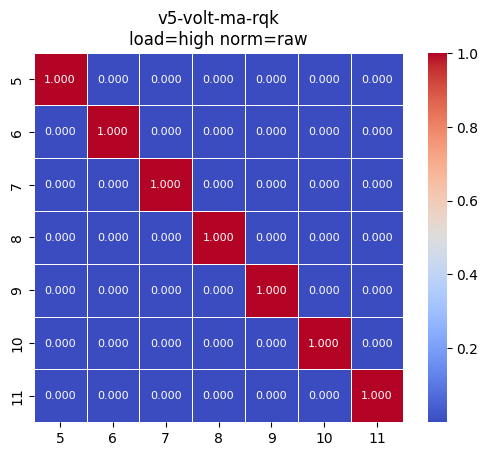

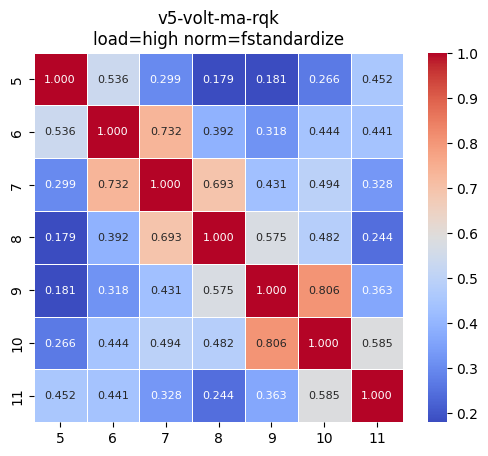

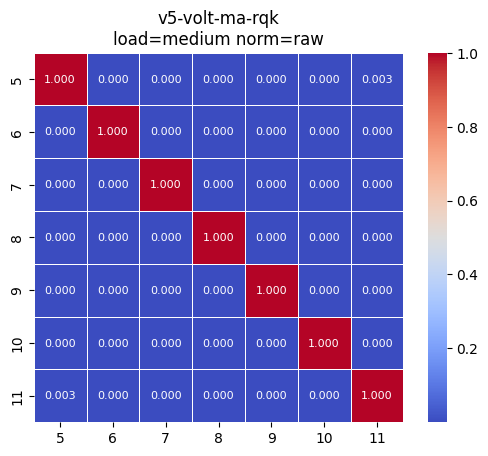

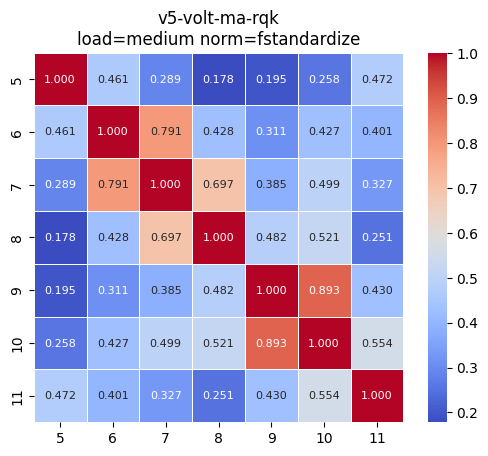

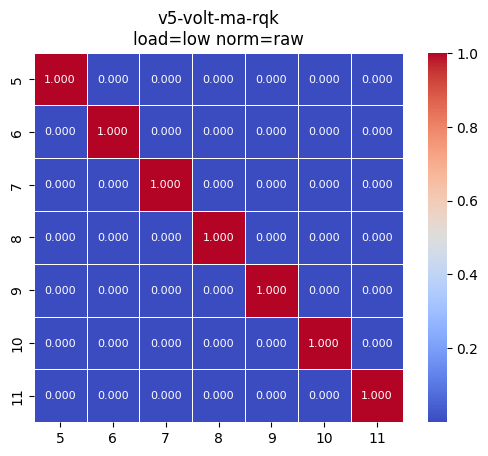

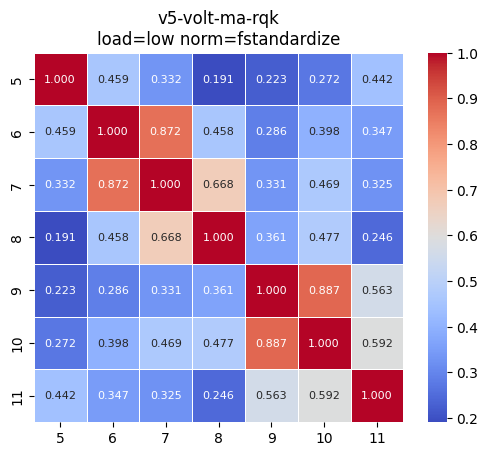

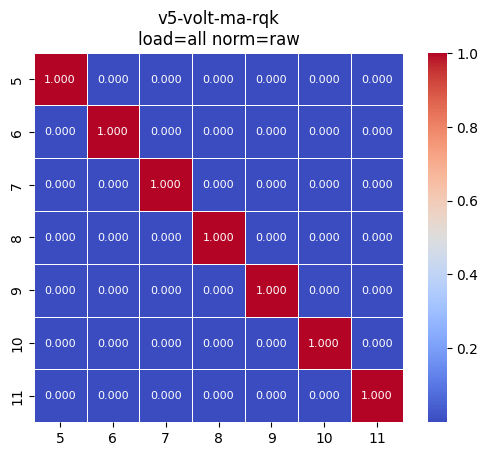

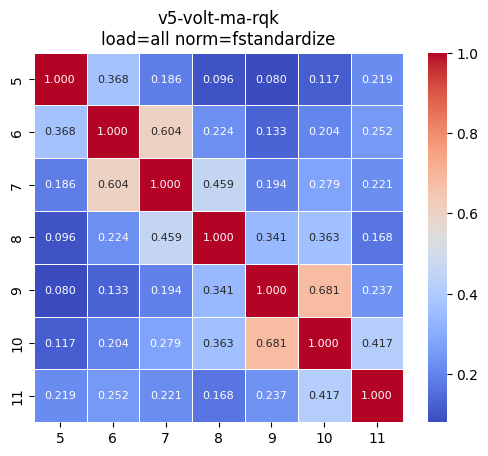

raw           fstandardize           
            rank      cond         rank       cond
load=high    7.0  1.000095          7.0  29.701588
load=medium  7.0  1.006173          7.0  42.404168
load=low     7.0  1.000170          7.0  45.978063
load=all     7.0  1.000060          7.0   9.539417

\begin{tabular}{lllll}
\toprule
 & \multicolumn{2}{r}{raw} & \multicolumn{2}{r}{fstandardize} \\
 & rank & cond & rank & cond \\
\midrule
load=high & $7$ & $1.0001$ & $7$ & $29.7016$ \\
load=medium & $7$ & $1.00617$ & $7$ & $42.4042$ \\
load=low & $7$ & $1.00017$ & $7$ & $45.9781$ \\
load=all & $7$ & $1.00006$ & $7$ & $9.53942$ \\
\bottomrule
\end{tabular}



In [12]:
run_multi_kernel_analysis(power_ma_ca, flatten_params+weighted_params, exp_name=f'{features}-ma')

## Magnitude ONLY

=======================rqk========================


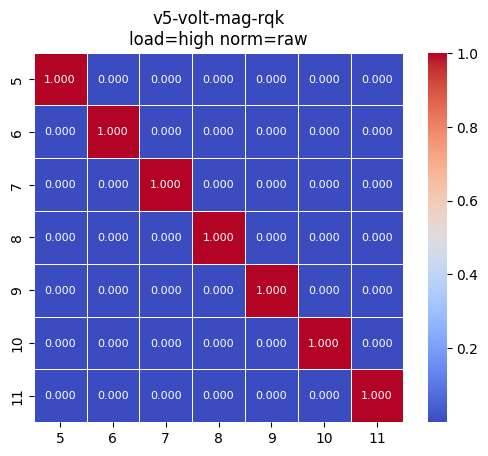

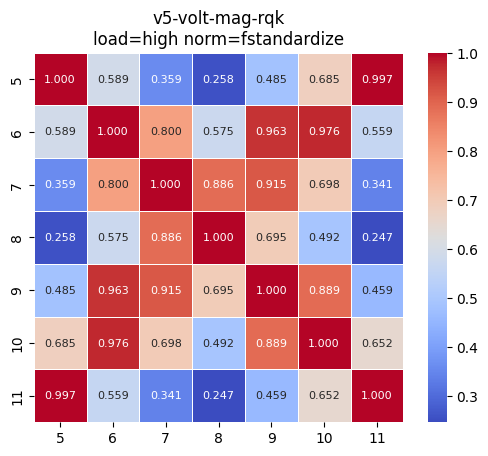

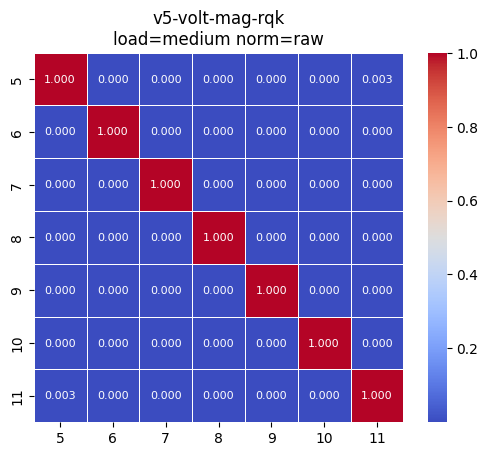

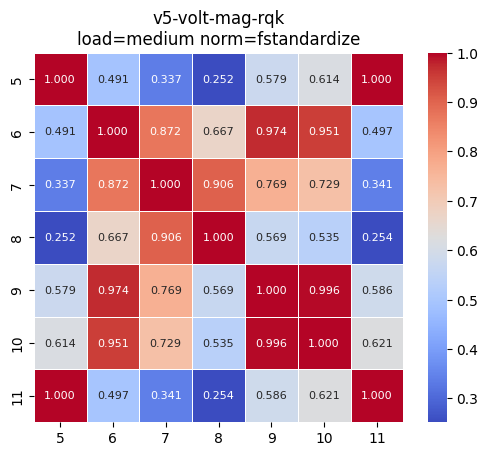

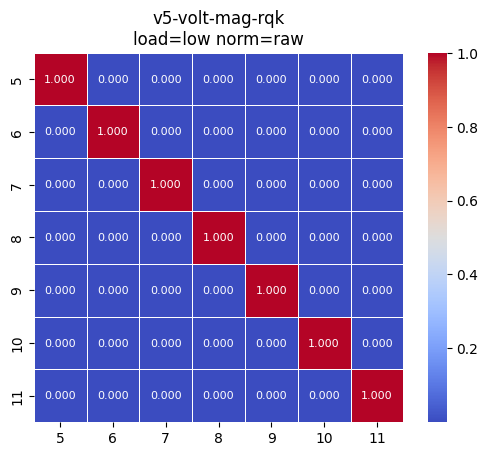

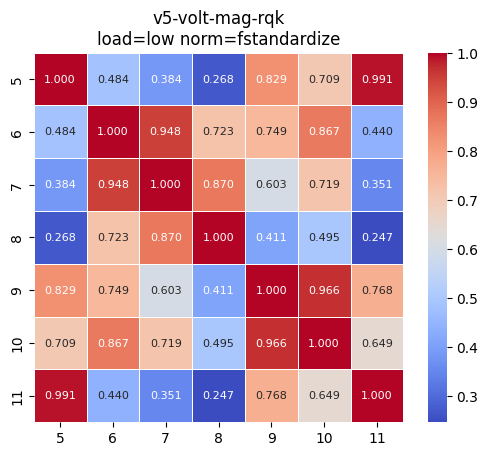

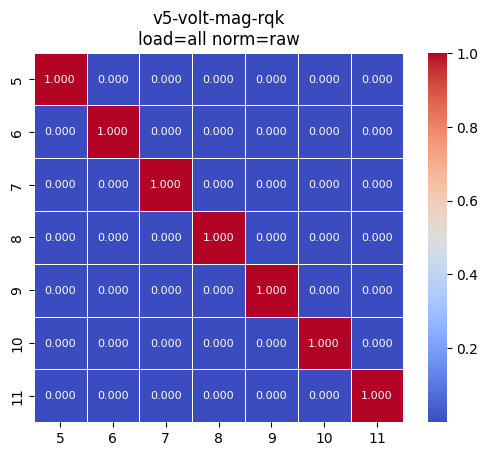

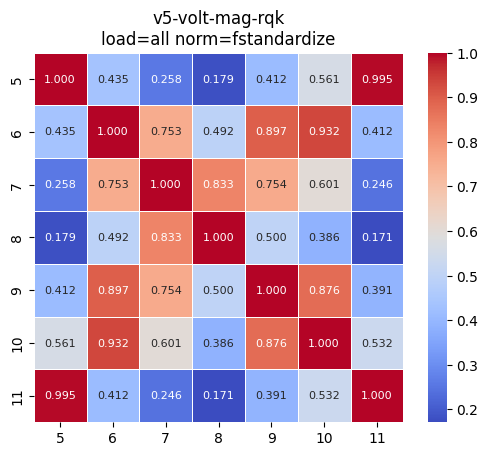

raw           fstandardize               
            rank      cond         rank           cond
load=high    7.0  1.000095          7.0   12659.571200
load=medium  7.0  1.006174          7.0  123665.461940
load=low     7.0  1.000170          7.0    4850.531661
load=all     7.0  1.000060          7.0    1130.459093

\begin{tabular}{lllll}
\toprule
 & \multicolumn{2}{r}{raw} & \multicolumn{2}{r}{fstandardize} \\
 & rank & cond & rank & cond \\
\midrule
load=high & $7$ & $1.0001$ & $7$ & $12659.6$ \\
load=medium & $7$ & $1.00617$ & $7$ & $123665$ \\
load=low & $7$ & $1.00017$ & $7$ & $4850.53$ \\
load=all & $7$ & $1.00006$ & $7$ & $1130.46$ \\
\bottomrule
\end{tabular}



In [11]:
run_multi_kernel_analysis(power_mag_ca, flatten_params, exp_name=f'{features}-mag')

## Angle ONLY

=======================rqk========================


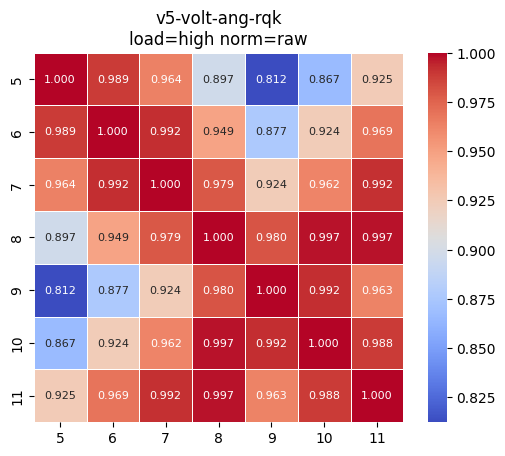

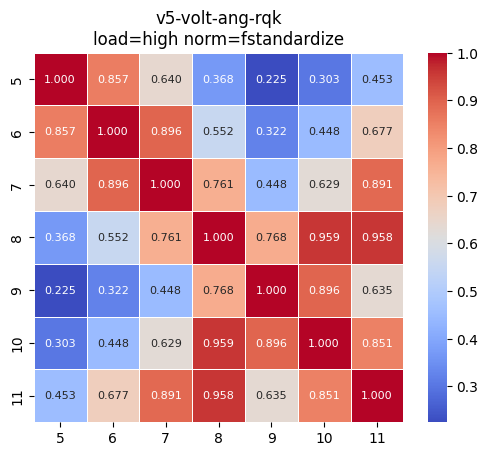

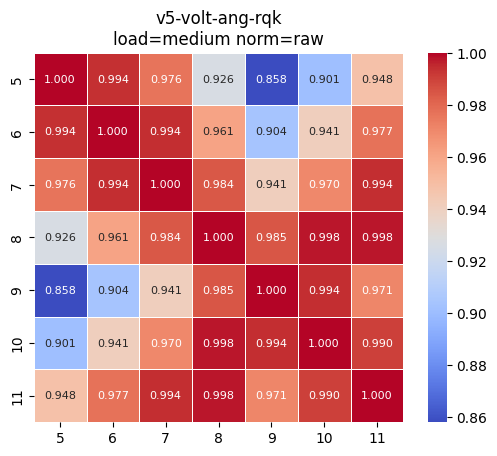

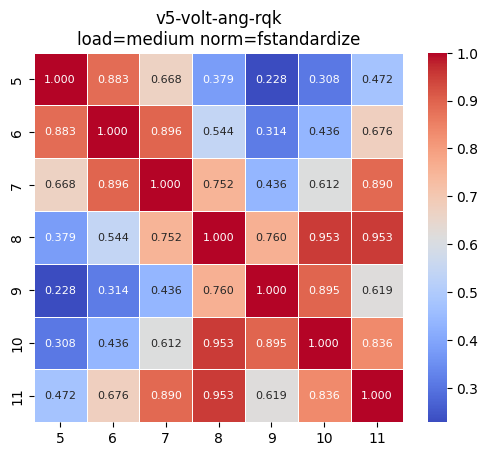

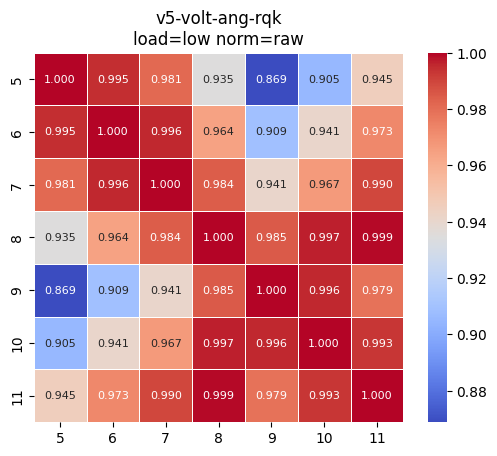

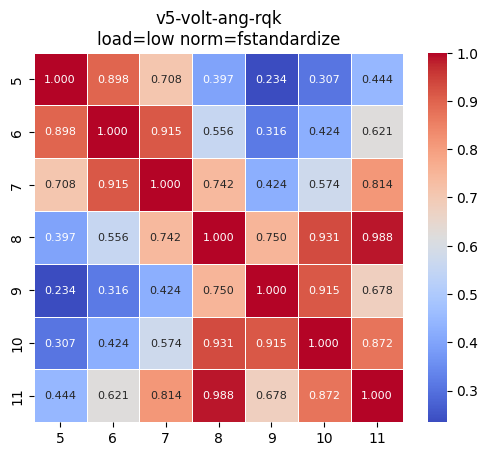

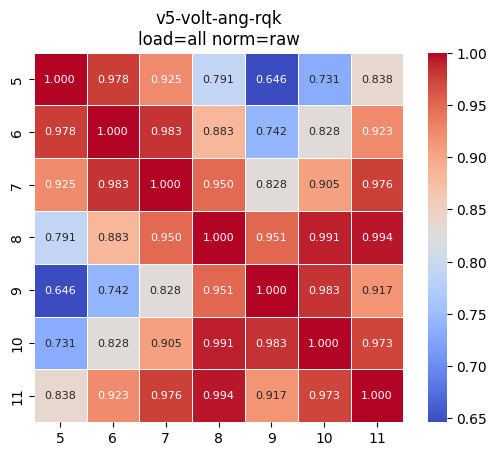

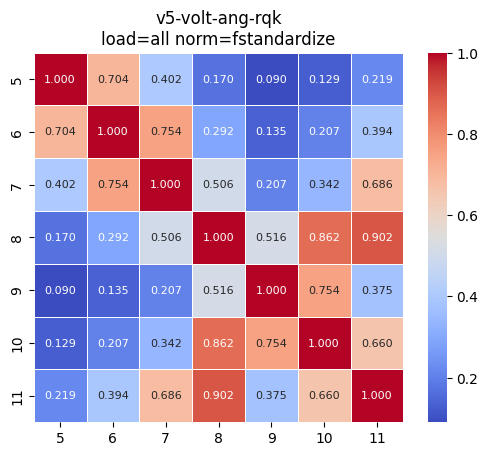

raw               fstandardize              
            rank          cond         rank          cond
load=high    7.0  4.883395e+09          7.0   6795.324684
load=medium  7.0  2.273072e+10          7.0   5279.475610
load=low     7.0  7.321835e+10          7.0  11911.179782
load=all     7.0  2.641191e+05          7.0    158.076972

\begin{tabular}{lllll}
\toprule
 & \multicolumn{2}{r}{raw} & \multicolumn{2}{r}{fstandardize} \\
 & rank & cond & rank & cond \\
\midrule
load=high & $7$ & $4.8834 \times 10^{09}$ & $7$ & $6795.32$ \\
load=medium & $7$ & $2.27307 \times 10^{10}$ & $7$ & $5279.48$ \\
load=low & $7$ & $7.32183 \times 10^{10}$ & $7$ & $11911.2$ \\
load=all & $7$ & $264119$ & $7$ & $158.077$ \\
\bottomrule
\end{tabular}



In [12]:
run_multi_kernel_analysis(power_ang_ca, flatten_params, exp_name=f'{features}-ang')

# Single Experiments

In [13]:
single_exp_path.mkdir(parents=True, exist_ok=True)

In [14]:
# Mag+Angle
power_ma_ca = KernelAnalysis(
    pmuds_class=pmuds_class,
    pmuds_kwargs=pmuds_kwargs,
    build_graph_kwargs=build_graph_kwargs,
    save_dir_path=multi_exp_path
)
print(pmuds_kwargs)
print('-'*50)
# Mag only 
pmuds_mag_kwargs = deepcopy(pmuds_kwargs)
for _, value in pmuds_mag_kwargs.items():
    value['drop_angle'] = True
power_mag_ca = KernelAnalysis(
    pmuds_class=pmuds_class,
    pmuds_kwargs=pmuds_mag_kwargs,
    build_graph_kwargs=build_graph_kwargs,
    save_dir_path=multi_exp_path
)
print(pmuds_mag_kwargs)
print('-'*50)
# Angle Only
pmuds_an_kwargs = deepcopy(pmuds_kwargs)
for _, value in pmuds_an_kwargs.items():
    value['drop_magnitude'] = True 
power_ang_ca = KernelAnalysis(
    pmuds_class=pmuds_class,
    pmuds_kwargs=pmuds_an_kwargs,
    build_graph_kwargs=build_graph_kwargs,
    save_dir_path=multi_exp_path
)
print(pmuds_an_kwargs)

{'load=high': {'load': 'high', 'topology': 'complete', 'drop_current': True}, 'load=medium': {'load': 'medium', 'topology': 'complete', 'drop_current': True}, 'load=low': {'load': 'low', 'topology': 'complete', 'drop_current': True}, 'load=all': {'load': ['high', 'medium', 'low'], 'topology': 'complete', 'drop_current': True}}
--------------------------------------------------
{'load=high': {'load': 'high', 'topology': 'complete', 'drop_current': True, 'drop_angle': True}, 'load=medium': {'load': 'medium', 'topology': 'complete', 'drop_current': True, 'drop_angle': True}, 'load=low': {'load': 'low', 'topology': 'complete', 'drop_current': True, 'drop_angle': True}, 'load=all': {'load': ['high', 'medium', 'low'], 'topology': 'complete', 'drop_current': True, 'drop_angle': True}}
--------------------------------------------------
{'load=high': {'load': 'high', 'topology': 'complete', 'drop_current': True, 'drop_magnitude': True}, 'load=medium': {'load': 'medium', 'topology': 'complete', 

## RQK

### Voltage All

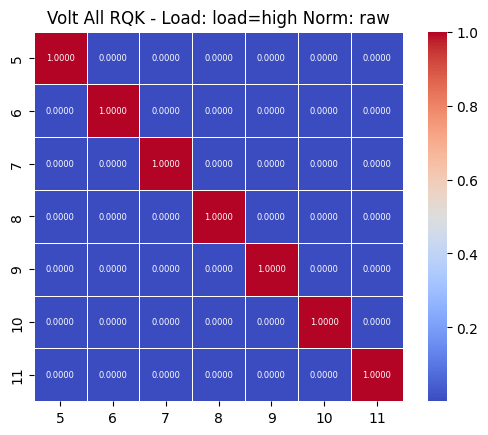

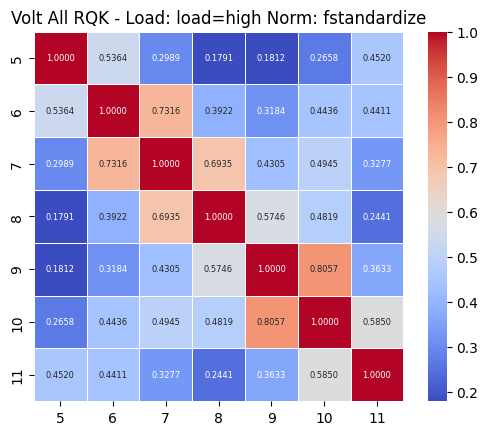

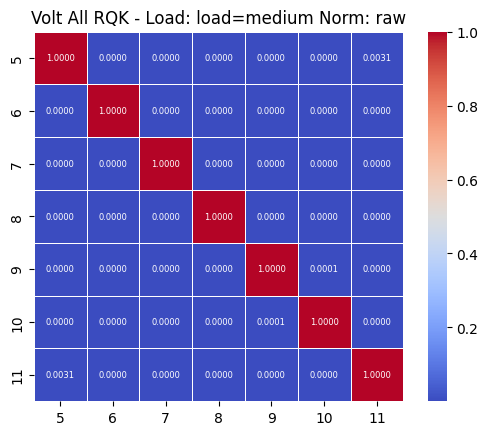

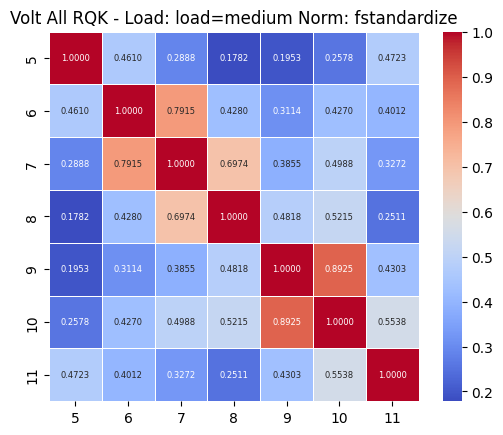

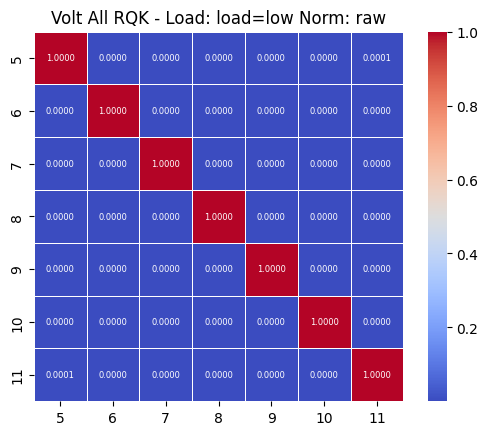

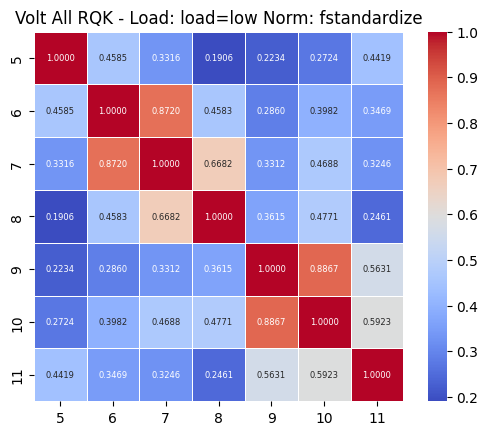

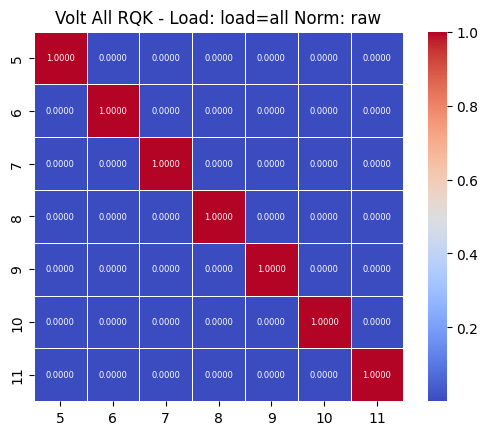

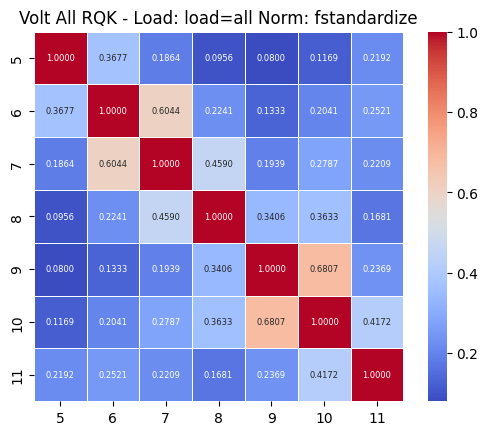

raw           fstandardize           
            rank      cond         rank       cond
load=high    7.0  1.000095          7.0  29.701588
load=medium  7.0  1.006173          7.0  42.404168
load=low     7.0  1.000170          7.0  45.978063
load=all     7.0  1.000060          7.0   9.539417

In [15]:
cond_df = power_ma_ca(
    kernel_fn=rqk, 
    title='Volt All RQK - Load: {0} Norm: {1}', 
    # save_filename='all-rqk.pdf',
    annot_kws={"fontsize":6},
    fmt='.4f',
)
display(cond_df)

In [16]:
fmt_cond_df = cond_df.map(lambda x:float_exponent_notation(x))
print(fmt_cond_df.to_latex())

\begin{tabular}{lllll}
\toprule
 & \multicolumn{2}{r}{raw} & \multicolumn{2}{r}{fstandardize} \\
 & rank & cond & rank & cond \\
\midrule
load=high & $7$ & $1.0001$ & $7$ & $29.7016$ \\
load=medium & $7$ & $1.00617$ & $7$ & $42.4042$ \\
load=low & $7$ & $1.00017$ & $7$ & $45.9781$ \\
load=all & $7$ & $1.00006$ & $7$ & $9.53942$ \\
\bottomrule
\end{tabular}



### Voltage Magnitude

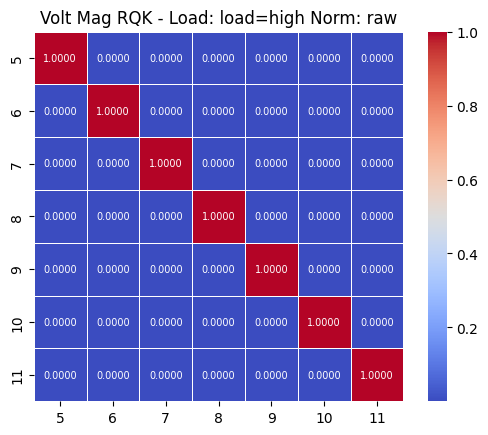

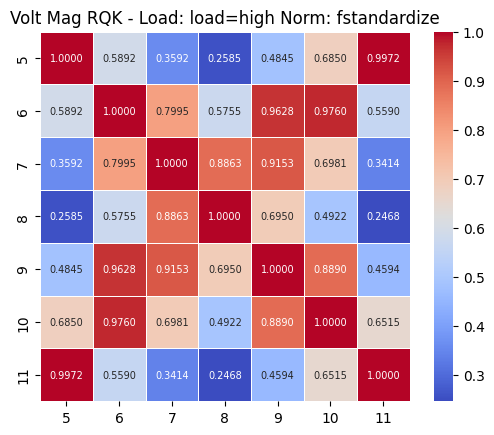

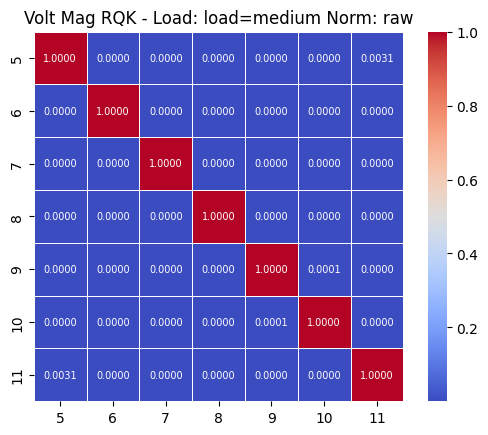

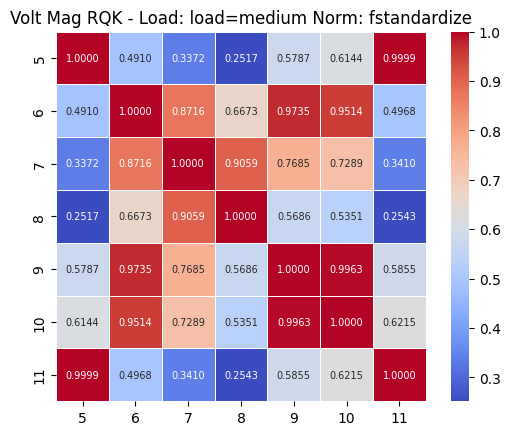

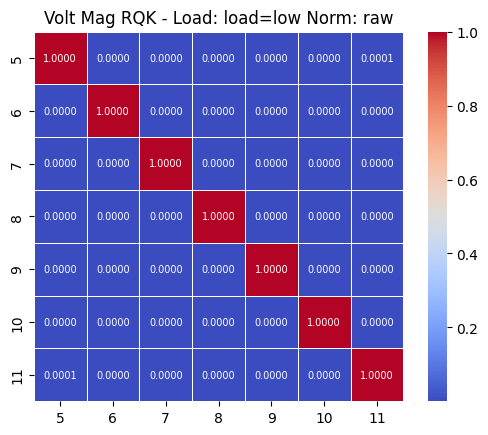

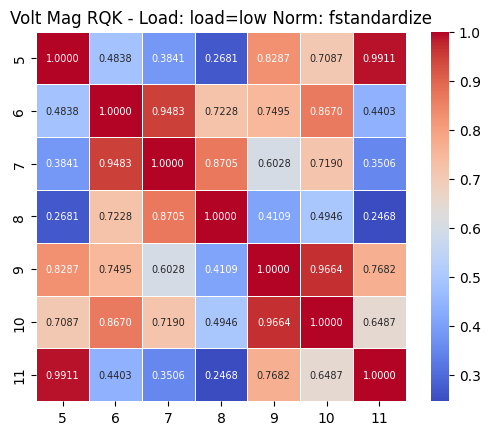

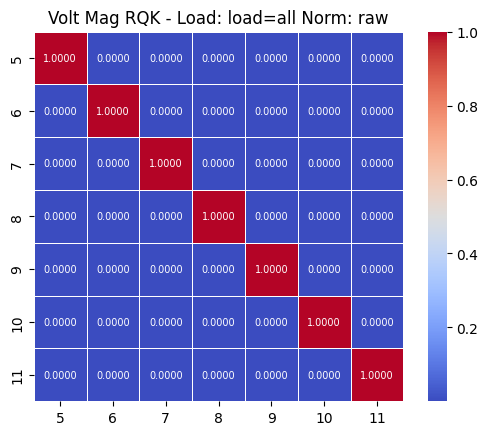

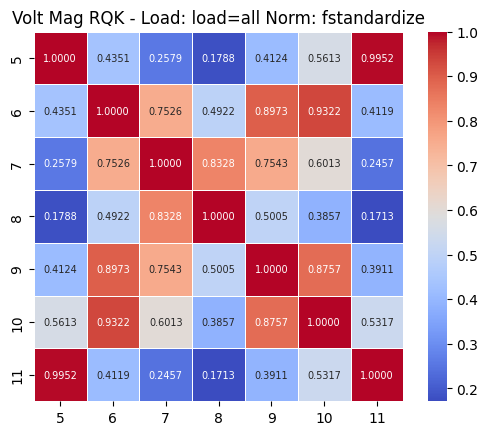

raw           fstandardize               
            rank      cond         rank           cond
load=high    7.0  1.000095          7.0   12659.571200
load=medium  7.0  1.006174          7.0  123665.461940
load=low     7.0  1.000170          7.0    4850.531661
load=all     7.0  1.000060          7.0    1130.459093

In [17]:
cond_ma_df = power_mag_ca(
    kernel_fn=rqk, 
    title='Volt Mag RQK - Load: {0} Norm: {1}', 
    # save_filename='ma-gram.pdf'
)
display(cond_ma_df)

In [18]:
fmt_cond_ma_df = cond_ma_df.map(lambda x:float_exponent_notation(x))
print(fmt_cond_ma_df.to_latex())

\begin{tabular}{lllll}
\toprule
 & \multicolumn{2}{r}{raw} & \multicolumn{2}{r}{fstandardize} \\
 & rank & cond & rank & cond \\
\midrule
load=high & $7$ & $1.0001$ & $7$ & $12659.6$ \\
load=medium & $7$ & $1.00617$ & $7$ & $123665$ \\
load=low & $7$ & $1.00017$ & $7$ & $4850.53$ \\
load=all & $7$ & $1.00006$ & $7$ & $1130.46$ \\
\bottomrule
\end{tabular}



### Voltage Angle

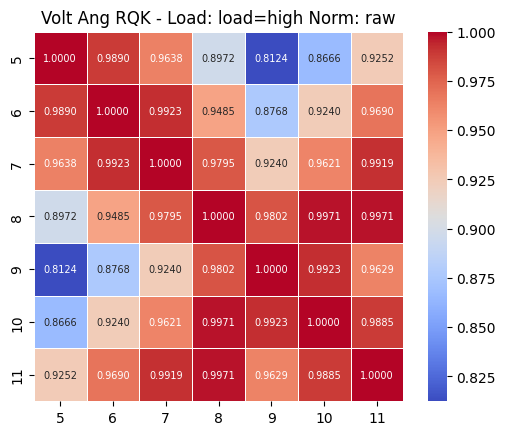

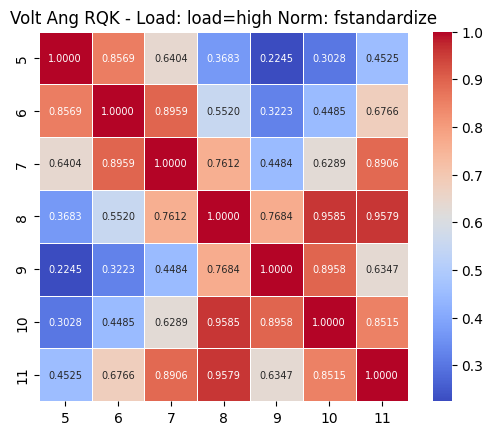

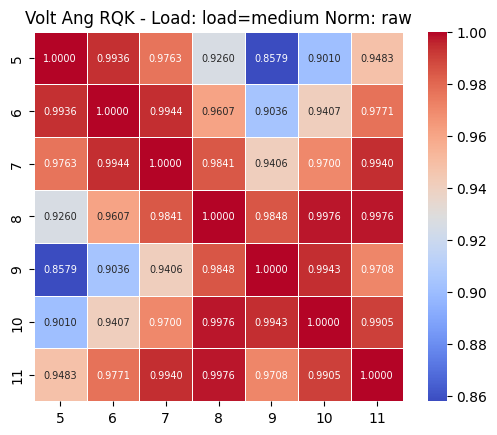

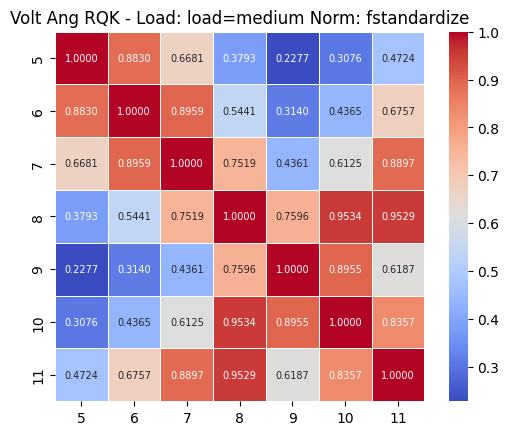

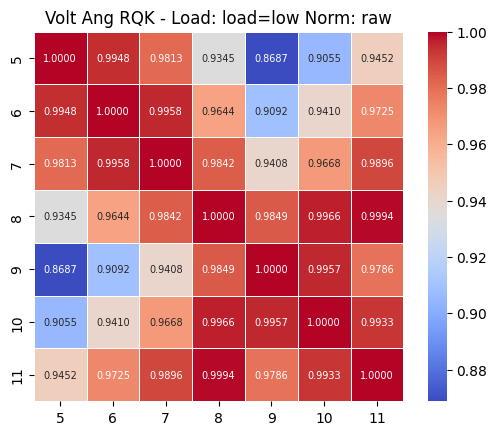

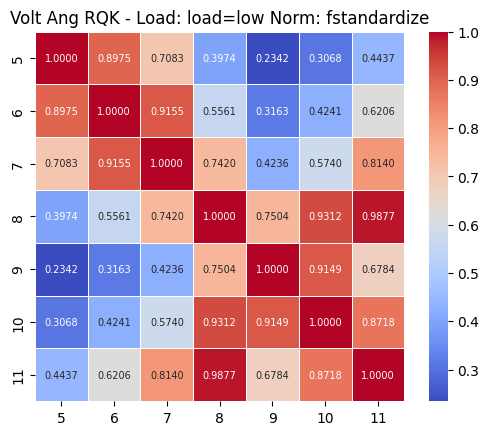

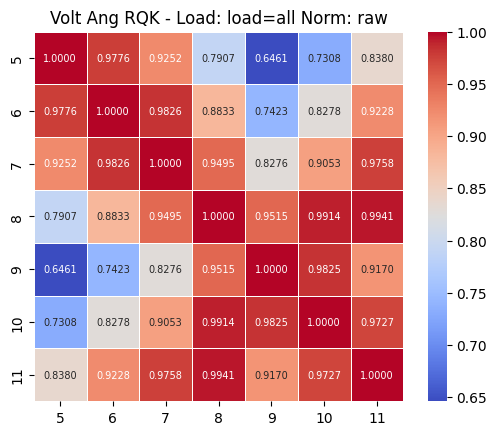

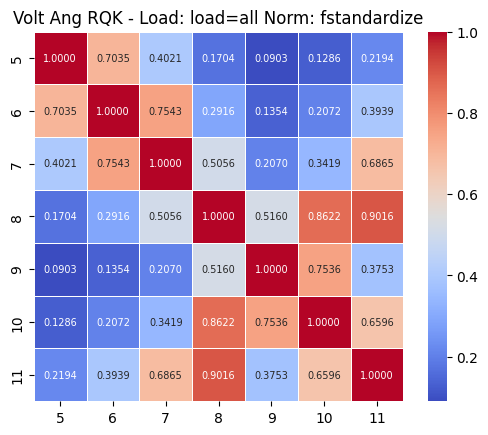

raw               fstandardize              
            rank          cond         rank          cond
load=high    7.0  4.883395e+09          7.0   6795.324684
load=medium  7.0  2.273072e+10          7.0   5279.475610
load=low     7.0  7.321835e+10          7.0  11911.179782
load=all     7.0  2.641191e+05          7.0    158.076972

In [19]:
cond_an_df = power_ang_ca(
    kernel_fn=rqk, 
    title='Volt Ang RQK - Load: {0} Norm: {1}', 
    # save_filename='an-gram.pdf'
)
display(cond_an_df)

In [20]:
fmt_cond_an_df= cond_an_df.map(lambda x:float_exponent_notation(x))
print(fmt_cond_an_df.to_latex())

\begin{tabular}{lllll}
\toprule
 & \multicolumn{2}{r}{raw} & \multicolumn{2}{r}{fstandardize} \\
 & rank & cond & rank & cond \\
\midrule
load=high & $7$ & $4.8834 \times 10^{09}$ & $7$ & $6795.32$ \\
load=medium & $7$ & $2.27307 \times 10^{10}$ & $7$ & $5279.48$ \\
load=low & $7$ & $7.32183 \times 10^{10}$ & $7$ & $11911.2$ \\
load=all & $7$ & $264119$ & $7$ & $158.077$ \\
\bottomrule
\end{tabular}

